In [1]:
#data analysis of spring dataset

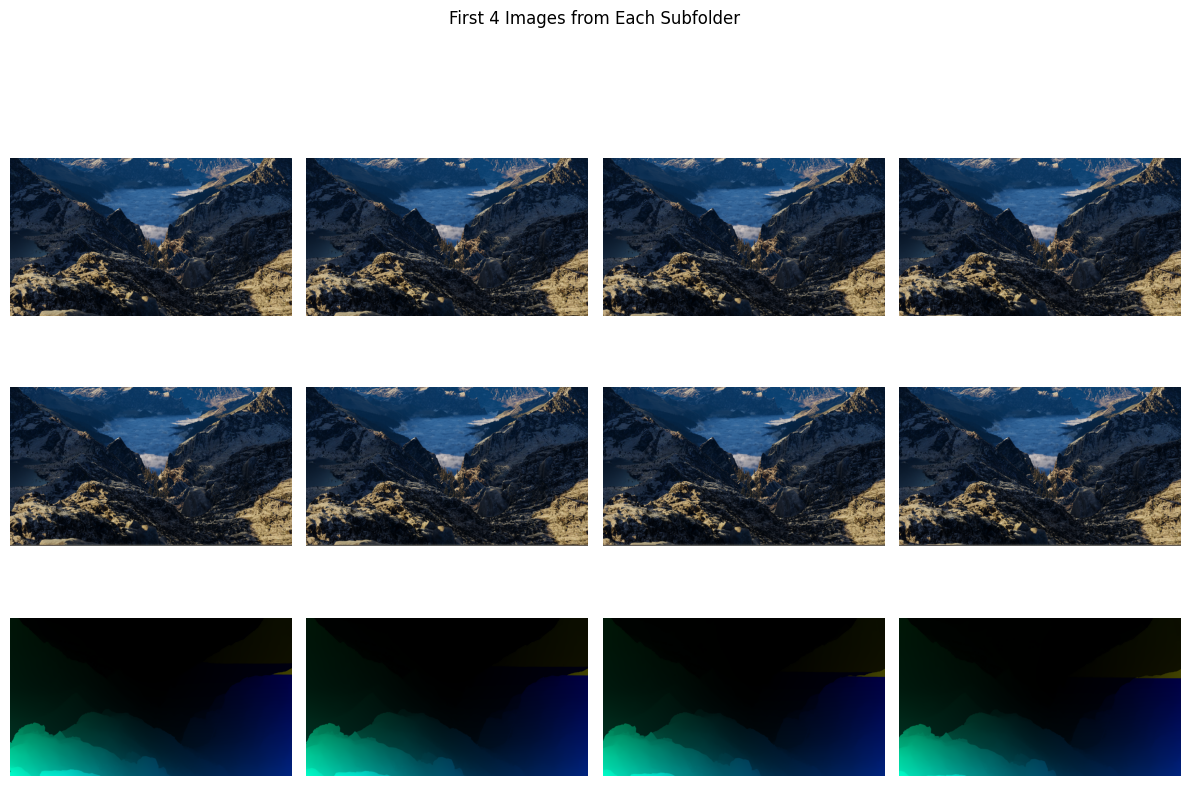

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def display_images(root_folder):
    # Define the subfolders
    subfolders = ['frame_left', 'encoded_left', 'flow_images']
    
    # Set up the figure with 3 rows and 4 columns
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))  # Adjust figsize for desired output size
    fig.suptitle("First 4 Images from Each Subfolder")
    
    # Loop over each subfolder and plot the first 4 images
    for i, subfolder in enumerate(subfolders):
        folder_path = os.path.join(root_folder, subfolder)
        images = sorted(os.listdir(folder_path))[:4]  # Get the first 4 images (sorted alphabetically)
        
        for j, image_name in enumerate(images):
            image_path = os.path.join(folder_path, image_name)
            img = Image.open(image_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')  # Hide axes for a cleaner look
            # axes[i, j].set_title(f"{subfolder} - {image_name}")
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
    plt.show()

# Usage example
root_folder = '/data/maryam.sana/datazips/spring/train/0001'
display_images(root_folder)


In [2]:
import h5py
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to read and extract optical flow data from an HDF5 (.flo5) file
def read_flo5_file(file_path):
    with h5py.File(file_path, 'r') as f:
        # Assuming the dataset key inside the HDF5 file contains flow data
        flow_data = f['flow'][:]  # Change 'flow' to your actual dataset key
        
        # Flow data is expected to be [H, W, 2] where the last dimension contains u and v components
        return flow_data

# Function to convert optical flow to RGB using HSV color space
def flow_to_color(flow):
    """Convert optical flow to RGB image using HSV color model."""
    h, w = flow.shape[:2]
    hsv = np.zeros((h, w, 3), dtype=np.float32)
    
    # Get flow components (u and v)
    flow_x = flow[:, :, 0]
    flow_y = flow[:, :, 1]

    # Ensure the data types are float32 (CV_32F)
    flow_x = flow_x.astype(np.float32)
    flow_y = flow_y.astype(np.float32)

    # Print flow data types and shapes for debugging
    print(f"flow_x dtype: {flow_x.dtype}, shape: {flow_x.shape}")
    print(f"flow_y dtype: {flow_y.dtype}, shape: {flow_y.shape}")

    # Convert flow vectors to magnitude and angle
    magnitude, angle = cv2.cartToPolar(flow_x, flow_y)

    # Normalize magnitude to [0, 1]
    hsv[..., 0] = angle * 180 / np.pi / 2  # Hue represents the angle
    hsv[..., 1] = 1  # Full saturation
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 1, cv2.NORM_MINMAX)  # Value represents the magnitude

    # Convert HSV to RGB for visualization
    rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    return rgb_flow

# Function to process .flo5 file and visualize/save the optical flow as an image
def process_flo5_file(flo5_file, output_image):
    # Read the optical flow data from the .flo5 (HDF5) file
    flow = read_flo5_file(flo5_file)
    
    # Convert the optical flow to a color representation
    flow_rgb = flow_to_color(flow)
    
    # Save the flow visualization as an image
    cv2.imwrite(output_image, (flow_rgb * 255).astype(np.uint8))
    print(f"Flow visualization saved as {output_image}")
    
    # Display the flow visualization
    plt.imshow(flow_rgb)
    plt.title('Optical Flow Visualization')
    plt.axis('off')
    plt.show()


if __name__ == "__main__":
    # Path to your .flo5 (HDF5) file
    flo5_file = '/data/maryam.sana/datazips/spring/train/0008/flow_FW_left/flow_FW_left_0007.flo5'  # Replace with the actual path
    
    # Output image path
    output_image = 'flow_visualization.png'
    
    # Process and visualize the .flo5 file
    # process_flo5_file(flo5_file, output_image)


In [1]:
from torch.utils.data import DataLoader
from src.train.video_dataset import *
import torch

# Define the dataset root directory and other parameters
root_dir = "/data/maryam.sana/datazips/spring/"
frame_dir = "frame_left"
optical_flow_dir = "flow_images"
encoded_frame_dir = "encoded_left"
resolution = 512  # Example resolution
global_type_list = []  # Populate with your global types as required
drop_txt_prob = 0.1  # Example probabilities
keep_all_cond_prob = 0.8
drop_all_cond_prob = 0.1
drop_each_cond_prob = [0.5,0.5]

# Initialize the custom dataset
dataset = UniVideoDataset(
    root=root_dir,
    frame_dir=frame_dir,
    optical_flow_dir=optical_flow_dir,
    encoded_frame_dir=encoded_frame_dir,
    global_type_list=global_type_list,
    resolution=resolution,
    drop_txt_prob=drop_txt_prob,
    keep_all_cond_prob=keep_all_cond_prob,
    drop_all_cond_prob=drop_all_cond_prob,
    drop_each_cond_prob=drop_each_cond_prob,
    split="train"
)

def custom_collate_fn(batch):
    # Separate out the parts of the batch that are strings and numpy arrays/tensors
    # print(batch.shape)
    txt_batch = [item['txt'] for item in batch]  # Extract 'txt'

    # Extract the image data (jpg) and ensure it has shape [5, 512, 512, 3] without adding a batch dimension
    jpg_batch = torch.cat([torch.tensor(item['jpg']) for item in batch], dim=0) if len(batch) > 1 else torch.tensor(batch[0]['jpg'])

    # Handle local and global conditions similarly
    local_conditions_batch = torch.cat([torch.tensor(item['local_conditions']) for item in batch], dim=0) if len(batch) > 1 else torch.tensor(batch[0]['local_conditions'])
    global_conditions_batch = torch.cat([torch.tensor(item['global_conditions']) for item in batch], dim=0) if len(batch) > 1 else torch.tensor(batch[0]['global_conditions'])

    # Return the combined dictionary
    return {
        'jpg': jpg_batch,  # This will have shape [5, 512, 512, 3] for each item
        'txt': txt_batch,  # Keep as a list of strings
        'local_conditions': local_conditions_batch,
        'global_conditions': global_conditions_batch
    }
    
# Initialize the DataLoader
dataloader = DataLoader(
    dataset,
    collate_fn=custom_collate_fn,
    num_workers=4,
    batch_size=1,
    pin_memory=True,
    shuffle=True,
    persistent_workers=True,
)


In [2]:

for batch in dataloader:
    # batch is now a dictionary, not a list of dictionaries
    images = batch['jpg']  # Image data, should be a tensor
    txt = batch['txt']  # Text/annotation data, a list of strings
    local_conditions = batch['local_conditions']  # Local conditions (optical flow and encoded frame)
    global_conditions = batch['global_conditions']  # Global conditions

    # Now you can iterate through the data if necessary or directly use it
    print("Images shape:", images.shape)  # Should be a tensor
    print("Local conditions shape:", local_conditions.shape)  # Should be a tensor
    # print("Global conditions shape:", global_conditions.shape)  # Should be a tensor
    print("Text data:", txt)  # List of text annotations or empty strings
    break


Images shape: torch.Size([3, 512, 512, 3])
Local conditions shape: torch.Size([3, 512, 512, 6])
Text data: [array(['predict next image', 'predict next image', 'predict next image'],
      dtype='<U18')]


In [1]:
import numpy as np
import re
from PIL import Image

def read_pfm(file):
    """Read a .pfm file and return the image data as a numpy array."""
    with open(file, 'rb') as f:
        header = f.readline().rstrip().decode('utf-8')
        color = header == 'PF'
        dim_match = re.match(r'^(\d+)\s(\d+)\s$', f.readline().decode('utf-8'))
        if not dim_match:
            raise ValueError("Malformed PFM header.")
        width, height = map(int, dim_match.groups())
        scale = float(f.readline().rstrip().decode('utf-8'))
        if scale < 0:  # Little-endian
            data_type = '<f4'
            scale = -scale
        else:
            data_type = '>f4'  # Big-endian
        data = np.fromfile(f, data_type)
        data = np.reshape(data, (height, width, 3) if color else (height, width))
        data = np.flipud(data)
    return data

def convert_pfm_to_image(pfm_path, image_path):
    """Convert a .pfm file to a standard image format."""
    # Read the .pfm file
    data = read_pfm(pfm_path)

    # Normalize the data to 0-255 for image conversion
    data = (data - data.min()) / (data.max() - data.min())  # Scale to [0, 1]
    data = (data * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8

    # Convert to PIL image and save
    image = Image.fromarray(data)
    image.save(image_path)
    print(f"Converted {pfm_path} to {image_path}")

# Usage example
pfm_file = '/data/maryam.sana/datazips/monkaa/train/funnyworld_camera2_augmented0_x2/into_future_left/OpticalFlowIntoFuture_0500_L.pfm'
image_file = 'image.png'
convert_pfm_to_image(pfm_file, image_file)


Converted /data/maryam.sana/datazips/monkaa/train/funnyworld_camera2_augmented0_x2/into_future_left/OpticalFlowIntoFuture_0500_L.pfm to image.png
